In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# dataset='census13'
# version='original'
def learning_performance(dataset,version):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/mine/learning_model_prediction/"+dataset+"_"+version+".pkl"
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)

    prediction=prediction.cpu().detach().numpy()
    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
    # print(prediction_values[:10])
    # print(len(prediction_values))
    
    q_error=[]
    MAE=[]
    MAPE=[]
    for i in range(len(prediction)):
        p=int(prediction[i]*data_length)
        l=int(label[i]*data_length)
        if p==0 and l==0:
            q_error.append(1)
        elif p==0:
            q_error.append(l)
        elif l==0:
            q_error.append(p)
        else:
            q_error.append(max(l/p,p/l))
        MAE.append(abs(l-p))
        if l!=0:
            MAPE.append(abs(l-p)/l)
        else:
            MAPE.append(p)
    plt.xlabel('cardinality')
    plt.ylabel('learning model result q_error')
    plt.scatter(label,q_error,label='q_error')
    plt.show()
    
    plt.xlabel('cardinality'+' (tuple number:'+str(data_length)+")")
    plt.ylabel('learning model result MAE')
    plt.scatter(label,MAE,label='MAE')
    plt.show()
    
    plt.xlabel('cardinality')
    plt.ylabel('learning model result MAPE')
    plt.scatter(label,MAPE,label='MAPE')
    plt.show()
    

# 学习模型(不包括树)本身的性能
其中1，2，3图分别对应着q_error,AE(absolute error),APE(absolute percentage error)

假设p : prediction, l : label

q_error=max($\frac{l}{p}$,$\frac{p}{l}$)

AE=$|l-p|$

APE=$\frac{|l-p|}{l}$

例如：第1/2/3幅图中（0.1，100）点表示cardinality label为总体10%的query其被学习模型预测的结果的
      q_error/AE/APE 为100

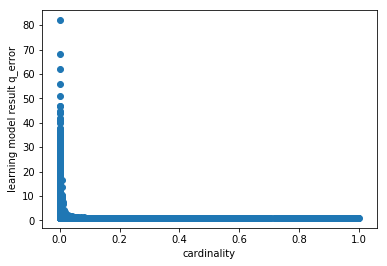

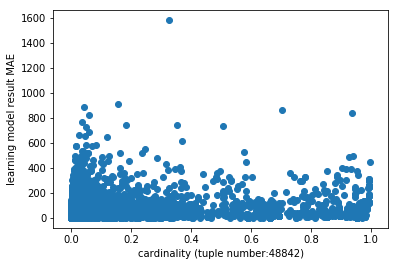

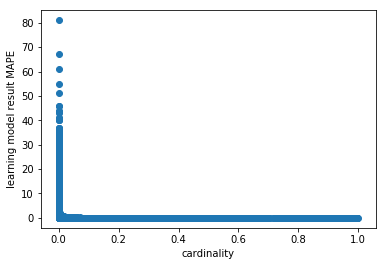

In [2]:
learning_performance('census13','original')

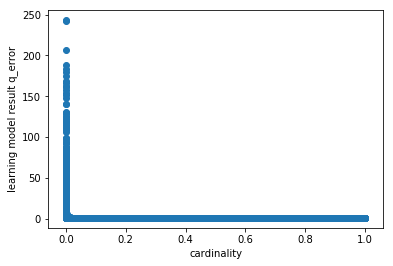

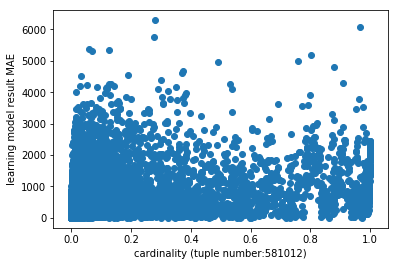

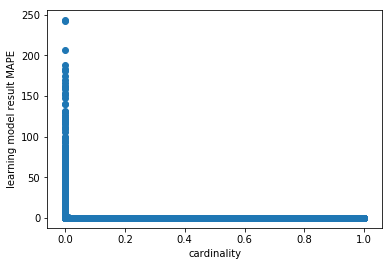

In [3]:
learning_performance('forest10','original')

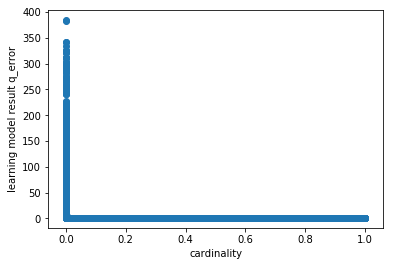

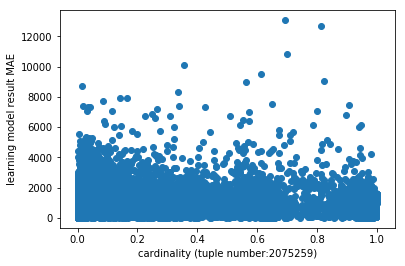

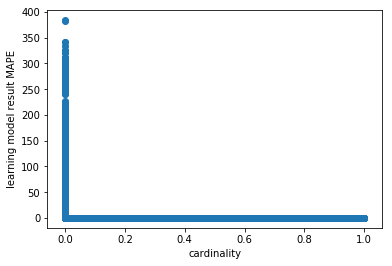

In [4]:
learning_performance('power7','original')

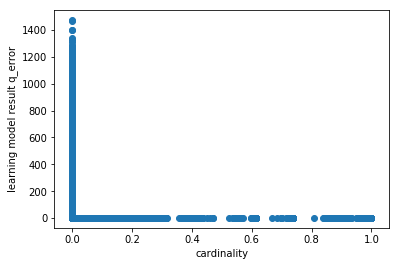

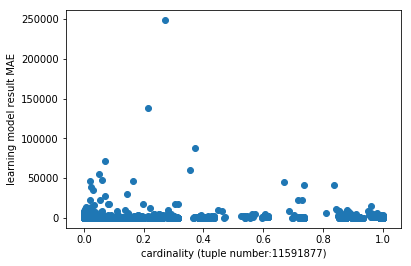

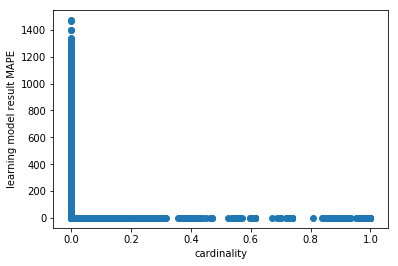

In [5]:
learning_performance('dmv11','original')

In [6]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# dataset='census1a3'
# version='original'


def drawing(dataset,version,rate):
    result_addr="./lecarb/estimator/mine/tree_inference_result/valid_"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/mine/learning_model_prediction/valid_"+dataset+"_"+version+".pkl"
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
       
    prediction=prediction.cpu().detach().numpy()
    count_prediction=[float(i) for i in prediction]

    prediction_values=sorted(Counter(count_prediction).keys(),key=lambda x:x,reverse=False)
    # print(prediction_values[:10])
    # print(len(prediction_values))
    label=np.around(label*data_length)
    label=[i[0] for i in label]
    

    loss=[] # 0.5*t+0.5*q_error
    t=[]
    mean_qerror=[]
    for threshold in prediction_values:
        add_time=0
        q_error=[]
        for i in range(len(prediction)):
            if prediction[i]<=threshold:
                q_error.append(1)
                add_time+=inference_time[i]
            else:
                p=np.around(prediction[i]*data_length)[0]
                
                
                l=label[i]
                if p==0 and l==0:
                    q_error.append(1)
                elif p==0:
                    q_error.append(l)
                elif l==0:
                    q_error.append(p)
                else:
                    q_error.append(max(p/l,l/p))
        add_time=add_time*1000/10000
        #add_time ms/query
        loss.append(add_time*rate+(1-rate)*np.mean(q_error))
        t.append(add_time)
        mean_qerror.append(np.mean(q_error))
    print("best eta:",prediction_values[loss.index(min(loss))])
    
    threshold=prediction_values[loss.index(min(loss))]
    add_time=0
    q_error=[]
    turn_to_precise=0
    for i in range(len(prediction)):
        if prediction[i]<=threshold:
            turn_to_precise+=1
            q_error.append(1)
            add_time+=inference_time[i]
        else:
            p=np.around(prediction[i]*data_length)[0]
            l=label[i]
            if p==0 and l==0:
                q_error.append(1)
            elif p==0:
                q_error.append(l)
            elif l==0:
                q_error.append(p)
            else:
                q_error.append(max(p/l,l/p))
    add_time=add_time*1000/10000
    print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
    print("average time:",add_time,"ms/query")
    print("turn_to_precise",turn_to_precise)
    
    plt.xlabel('eta')
    plt.ylabel('loss')
    plt.plot(prediction_values,loss)
    plt.show()
    
    plt.xlabel('eta')
    plt.ylabel('incremented time of using tree')
    plt.plot(prediction_values,t)
    plt.show()
    
    plt.xlabel('eta')
    plt.ylabel('mean q_error after using tree')
    plt.plot(prediction_values,mean_qerror)
    plt.show()
    
    return prediction_values,loss,t,mean_qerror

In [7]:
import numpy as np
from scipy.optimize import curve_fit,minimize
import matplotlib.pyplot as mpl

from sympy import symbols, diff
from sympy.functions import exp

def func1_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))
    derivative_f = diff(f, x)
    return f,derivative_f

def func2_for_diff(a,x0,sigma):
    x=symbols('x')
    f=a*exp(-(x-x0)**2/(2*sigma**2))+1
    derivative_f = diff(f, x)
    return f,derivative_f

# Let's create a function to model and create data
def func1(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

def func2(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))+1

def exponen(x,a,b,lamb):
    if type(x)==type([]):
        x=np.array(x)
    return a-b*np.exp(-(lamb*x))

def exponen_for_diff(a,b,lamb):
    x=symbols('x')
    f=a-b*exp(-(lamb*x))
    derivative_f = diff(f, x)
    return f,derivative_f

def fit2(x,y,fit_type):
    plt.plot(x, y, c='k', label='data')
    plt.scatter(x, y)
    if fit_type==1:
        popt, pcov = curve_fit(exponen, x, y,maxfev=1000000)
        ym = exponen(x, popt[0], popt[1], popt[2])
    elif fit_type==2:
        popt, pcov = curve_fit(func2, x, y,maxfev=1000000)
        ym = func2(x, popt[0], popt[1], popt[2])
    else:
        print("wrong type")
        return
        
    #popt returns the best fit values for parameters of the given model (func)

    plt.plot(x, ym, c='r', label='fit')
    plt.legend()
    plt.show()
    return popt

def exponent_func(a,b,lamb):
    f=lambda x:a-b*np.exp(-(lamb*x))
    return f

def func2_func(a,x0,sigma):
    f=lambda x:a*np.exp(-(x-x0)**2/(2*sigma**2))+1
    return f



In [11]:
def fit_and_find_best_eta(prediction_values,t,mean_qerror,rate):
    x=symbols('x')
    popt1=fit2(prediction_values,t,fit_type=1)
    popt2=fit2(prediction_values,mean_qerror,fit_type=2)
    f1,_=exponen_for_diff(popt1[0],popt1[1],popt1[2])
    f2,_=func2_for_diff(popt2[0],popt2[1],popt2[2])
    f=rate*f1+(1-rate)*f2
    print(f)
    print("-----------------")
    
    func_f1=exponent_func(popt1[0],popt1[1],popt1[2])
    func_f2=func2_func(popt2[0],popt2[1],popt2[2])
    func_f=lambda x:rate*func_f1(x)+(1-rate)*func_f2(x)
    result=minimize(func_f,x0=[0.5],method='SLSQP',bounds=[(0,1)])

    a=[i/10000 for i in range(0,10000)]
    b=[f.subs(x,i) for i in a]
    plt.plot(a,b)
    best_eta=result['x'][0]
    print("best eta:",best_eta)
#     print("loss:",f.subs(x,best_eta))
#     print("time:",f1.subs(x,best_eta))
#     print("mean_qerror:",f2.subs(x,best_eta))
    plt.scatter(result['x'][0],f.subs(x,result['x'][0]),color='r')
    plt.show()
    return best_eta


def test_for_best_eta(dataset,version,best_eta):
    result_addr="./lecarb/estimator/mine/tree_inference_result/"+dataset+"_"+version+".pkl"
    with open(result_addr, 'rb') as f:
        [inference_result,inference_time] = pickle.load(f)

    addr="./lecarb/estimator/mine/learning_model_prediction/test_"+dataset+"_"+version+".pkl"
    with open(addr, 'rb') as f:
        [prediction,label,data_length] = pickle.load(f)
        
    label=np.around(label*data_length)
    label=[i[0] for i in label]
    
#     for i in range(100):
#         print(label[i],inference_result[i])
#     return
    
    prediction=prediction.cpu().detach().numpy()
    add_time=0
    q_error=[]
    turn_to_precise=0
    for i in range(len(prediction)):
        if prediction[i]<=best_eta:
            q_error.append(1)
            turn_to_precise+=1
            add_time+=inference_time[i]
        else:
            p=np.around(prediction[i]*data_length)[0]
            l=label[i]
            if p==0 and l==0:
                q_error.append(1)
            elif p==0:
                q_error.append(l)
            elif l==0:
                q_error.append(p)
            else:
                q_error.append(max(p/l,l/p))
    add_time=add_time*1000/10000
    print("max:",np.max(q_error),'99th:',np.percentile(q_error,99),'95th:',np.percentile(q_error,95),'90th:',np.percentile(q_error,90),'75th:',np.percentile(q_error,75),'50th:',np.percentile(q_error,50),'25th:',np.percentile(q_error,25),'mean:',np.mean(q_error))
    print("average incremental time:",add_time,"ms/query")
    print("turn_to_precise",turn_to_precise)
    


# eta-loss/time/mean q_error 曲线

三幅图中的eta表达含义是一样的：例如，eta取值为0.2时，表示学习模型预测值<=0.2时相信树结构，>0.2时相信学习模型

t : time

mqe : mean q_error

$loss=t*rate+mqe*(1-rate)$

三幅图分别含义：

eta-loss图中（0.2，1.25）表示，如果eta取值为0.2，则学习模型+树的loss为1.25   

eta-time图中表示树结构所增加的时间，例如（0.2，1.5）表示，当eta为0.2时，使用树结构的所有query（不包含只使用学习模型的部分）平均下来每条query要多花费1.5ms

eta-mean q_error图中，（0.2，1.5）表示当eta为0.2时，所有query(包括只使用学习模型以及使用学习模型+树）的平均q_error为1.5

这里的best\_eta1是直接遍历eta找到的.

-----------------------------------------------------------------------------------

接着利用curve_fit函数对于eta-t, eta-mqe, eta-loss 曲线进行拟合.(原理：非线性最小二乘曲线拟合)

其中
eta-t的初始点为(0,0),因此利用函数$f(x) = a-be^{-\lambda x}$ 进行拟合

eta-mqe从一个较高的点出发,随着eta的增大逐渐靠近并最终与直线y=1相交,利用函数$g(x)=1+ae^{-\frac{(x-x_{0})^{2}}{2\sigma^{2}}}$进行拟合

最终,eta-loss曲线拟合函数为w(x)=0.5*f(x)+0.5*g(x)

在此基础上利用scipy库中的minimize函数进行函数最小值点(best\_eta,best\_loss)的求解(原理：SLSQP，SequentialLeastSquaresProgramming,序列最小二乘法),并测得在该$eta$值的情况时模型总体性能(q_error,time等)

这里的best\_eta2是通过函数拟合并求最小值点得到的

max,99th,95.... : 这些指标是在best\_eta2的情况下,模型的q\_error指标

average incremental time : 指的是在best\_eta2的情况下树结构平均所增加的inference时间

turn_to_precise : 指的是在best\_eta2的情况下10000条query中有多少条query是使用了树结构的

------------------------------------------------------------------------------------

可以看出best_eta1, best_eta2很接近,表明拟合效果较好.

# census13

best eta: 0.0025538806803524494
max: 13.0 99th: 2.397155935764315 95th: 1.4332418441772456 90th: 1.174705231189728 75th: 1.0162457823753357 50th: 1.0 25th: 1.0 mean: 1.0804437354445457
average time: 0.24660792350769042 ms/query
turn_to_precise 5324


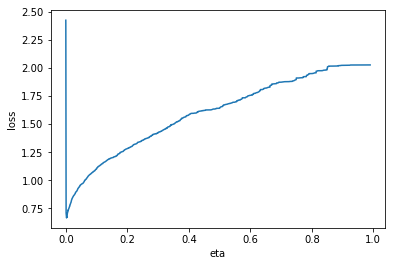

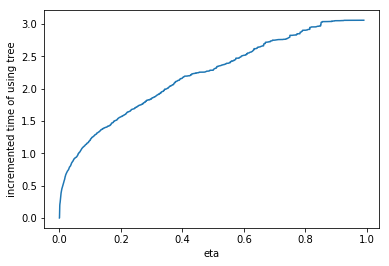

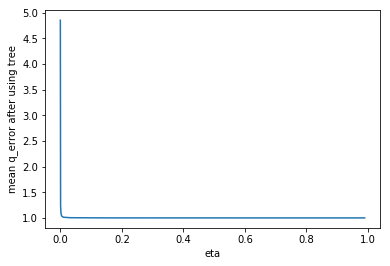

In [9]:
prediction_values,loss,t,mean_qerror=drawing('census13','original',0.5)

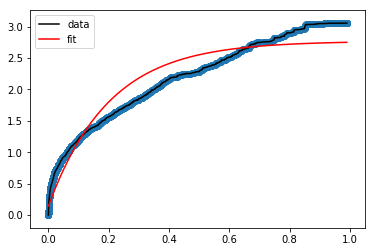

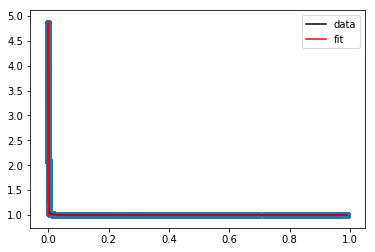

1.88504394249593 + 1.94413775108206*exp(-7804043.0140566*(x - 0.000105331350150871)**2) - 1.31531630347144*exp(-4.98915252180578*x)
-----------------
best eta: 0.0011489645004669144


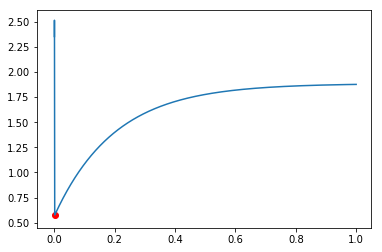

max: 68.0 99th: 4.75 95th: 1.8064651131629943 90th: 1.3560709953308105 75th: 1.0406939387321472 50th: 1.0002028942108154 25th: 1.0 mean: 1.2309928567051887
average incremental time: 0.26784017086029055 ms/query
turn_to_precise 4840


In [12]:
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta("census13",'original',best_eta)

# forest10

best eta: 3.7848552892683074e-05
max: 243.0 99th: 59.0 95th: 23.0 90th: 5.502941176470599 75th: 1.5040704648279637 50th: 1.038628478416347 25th: 1.00263976948672 mean: 4.111639419685534
average time: 0.7371992588043212 ms/query
turn_to_precise 1383


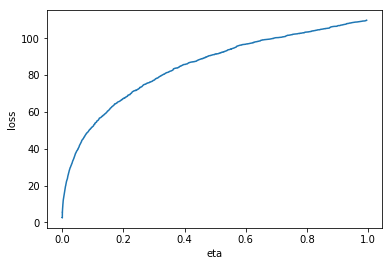

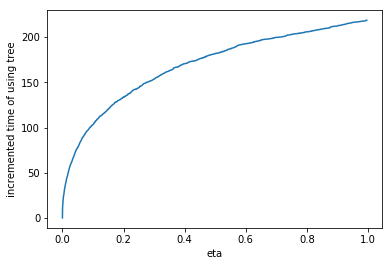

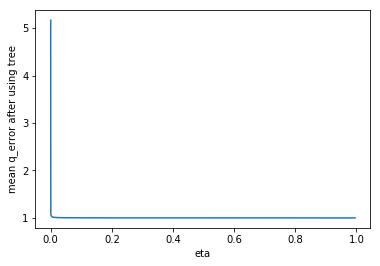

In [13]:
prediction_values,loss,t,mean_qerror=drawing('forest10','original',0.5)

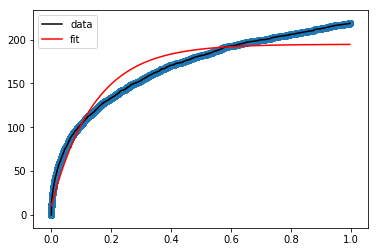

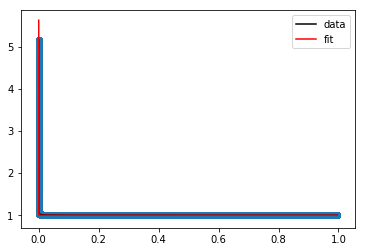

97.7892983346168 + 94.9946450425645*exp(-8269075.38505052*(x + 0.000669119045775861)**2) - 92.08991770839*exp(-7.01666803951026*x)
-----------------
best eta: 0.0003000836881740049


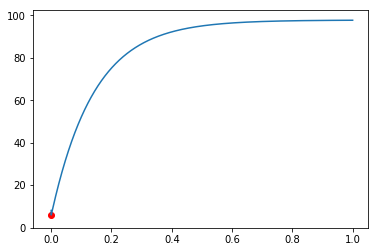

max: 198.0 99th: 2.8448884846567553 95th: 1.6029891974204218 90th: 1.2894096165550826 75th: 1.0491773447344688 50th: 1.0032537970197357 25th: 1.0 mean: 1.219637251931502
average incremental time: 11.332088923454284 ms/query
turn_to_precise 3668


In [14]:
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta("forest10",'original',best_eta)

# power7

best eta: 0.00016102522204164416
max: 384.0 99th: 2.0583382352941175 95th: 1.180094406553694 90th: 1.052111144055842 75th: 1.0064104658846824 50th: 1.0010445382087998 25th: 1.0002938263446521 mean: 1.207355527112461
average time: 0.27812240123748777 ms/query
turn_to_precise 784


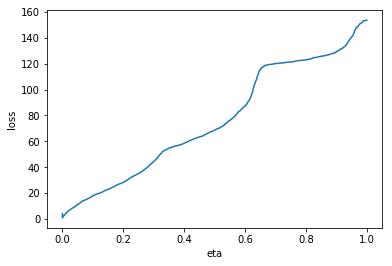

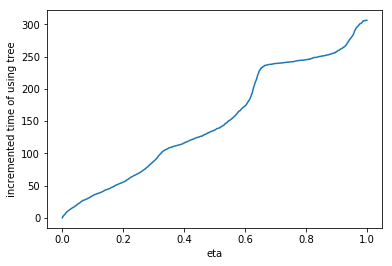

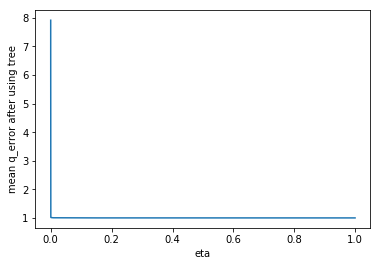

In [15]:
prediction_values,loss,t,mean_qerror=drawing('power7','original',0.5)

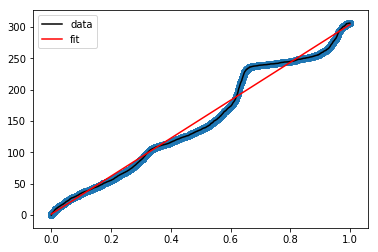

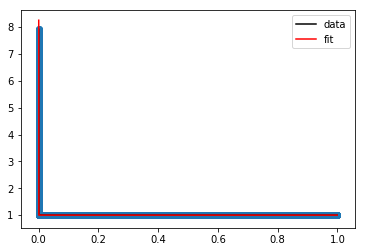

471932.396778242 + 4.123390997583*exp(-110318442.751311*(x + 7.13502175184808e-6)**2) - 471931.123343666*exp(-0.000320765128301097*x)
-----------------
best eta: 0.0002511403625607346


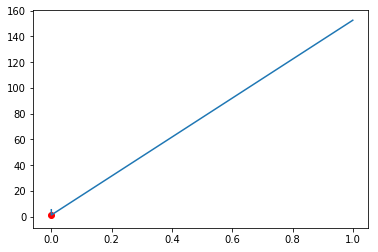

max: 8.394366197183098 99th: 1.7028614558672315 95th: 1.1384941443978072 90th: 1.0436500697458548 75th: 1.0057569987611 50th: 1.0009829296724315 25th: 1.0002665431940454 mean: 1.0341018636931183
average incremental time: 1.0060397624969482 ms/query
turn_to_precise 854


In [16]:
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta("power7",'original',best_eta)

# dmv11

best eta: 0.00017469367594458163
max: 12.586021505376344 99th: 1.7069651908023487 95th: 1.1281743407641391 90th: 1.0333457389268699 75th: 1.0035424096056076 50th: 1.000283148256452 25th: 1.0000132473532455 mean: 1.0303741293002568
average time: 0.15652227401733398 ms/query
turn_to_precise 2038


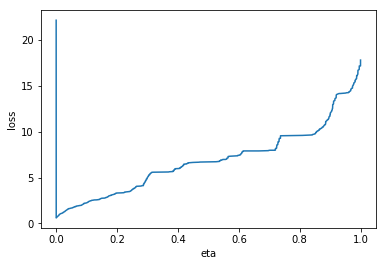

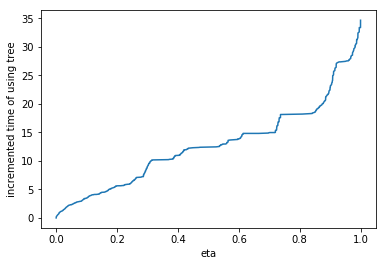

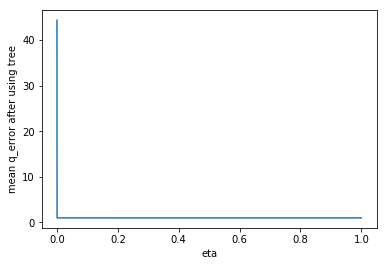

In [17]:
prediction_values,loss,t,mean_qerror=drawing('dmv11','original',0.5)

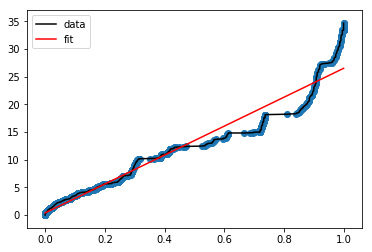

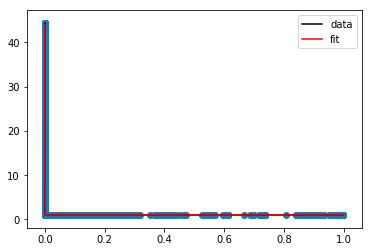

84668.6512236234 + 21.4665655250619*exp(-258275829.181826*(x - 6.54339139634973e-6)**2) - 84667.9617244047*exp(-0.000154197084434674*x)
-----------------
best eta: 0.00022362890659718775


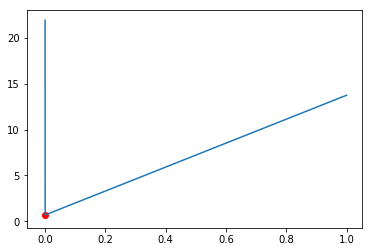

max: 5.006182380216384 99th: 1.507391431663126 95th: 1.1052393292961487 90th: 1.029987110066361 75th: 1.003632747034008 50th: 1.000288762103358 25th: 1.0000113017476395 mean: 1.023816326832603
average incremental time: 0.5604452610015869 ms/query
turn_to_precise 2191


In [18]:
best_eta=fit_and_find_best_eta(prediction_values,t,mean_qerror,rate=0.5)
test_for_best_eta("dmv11",'original',best_eta)